In [1]:
import os
from sys import getsizeof

import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
train_path = "new_train.csv"
image_path = "new_train"
test_path = "test.csv"

In [21]:
class Modelling:
    def __init__(self, train_path, test_path, image_path):
        self.train_data = pd.read_csv(train_path)
        self.test_data = pd.read_csv(test_path) 
        self.image_path = image_path
        
        self.X_train, self.X_val, self.y_train, self.y_val = None, None, None, None
        self.X_test = None

        self.models = {}

        self.optimizer = keras.optimizers.Adam(learning_rate=0.001)
        
    def prepare_data(self):
        amount_of_images = 1000
        scaler = StandardScaler() 
        
        X = self.train_data.drop(['Price'], axis=1)
        y = self.train_data['Price']
        
        X_scaled = scaler.fit_transform(X)

        images = np.empty((amount_of_images, 512, 512, 3), dtype=np.uint8)
        for i, image in enumerate(os.listdir(self.image_path)[:amount_of_images]):
            image = cv.imread(f'{self.image_path}/{image}')
            images[i, ...] = image

        self.X_train_csv, self.X_val_csv, self.X_train_img, self.X_val_img, self.y_train, self.y_val = \
        train_test_split(X_scaled[:amount_of_images], images, y[:amount_of_images], test_size=0.2, random_state=42)
        
        #Standariseren 
        self.X_test = scaler.transform(self.test_data)

    def train_NN(self):
        if all(data is not None for data in [self.X_train_csv, self.X_val_csv, self.y_train, self.y_val, self.X_test]):
            self.models['NN'] = keras.Sequential()
            
            self.models['NN'].add(layers.Dense(256, activation='relu', input_shape=(self.X_train_csv.shape[1],)))
            self.models['NN'].add(layers.Dropout(0.5))
            self.models['NN'].add(layers.Dense(128, activation='relu'))
            self.models['NN'].add(layers.Dropout(0.3))
            self.models['NN'].add(layers.Dense(64, activation='relu'))
            self.models['NN'].add(layers.Dense(1))
            
            #Model
            self.models['NN'].compile(optimizer=self.optimizer, loss='mean_absolute_percentage_error')
            
            #Early stopping
            early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
            
            #Train het model
            self.models['NN'].fit(self.X_train_csv, self.y_train, epochs=50, batch_size=32, \
                                  validation_data=(self.X_val_csv, self.y_val), callbacks=[early_stopping])
        else:
            print("Data is not prepared... run prepare_data() first!")

    def train_CNN(self):
        img_input = layers.Input(shape=(512, 512, 3), name="image")
        csv_input = layers.Input(shape=(6), name="csv")
        
        # define layers for image data 
        x_img = layers.experimental.preprocessing.Rescaling(1./255)(img_input)
        x_img = layers.Conv2D(16, 3, padding='same', activation='relu', name="conv1_img")(x_img)
        x_img = layers.MaxPooling2D(name="mxp1_img")(x_img)
        x_img = layers.Conv2D(32, 3, padding='same', activation='relu', name="conv2_img")(x_img)
        x_img = layers.MaxPooling2D(name="mxp2_img")(x_img)
        x_img = layers.Conv2D(32, 3, padding='same', activation='relu', name="conv3_img")(x_img)
        x_img = layers.MaxPooling2D(name="mxp3_img")(x_img)
        x_img = layers.Flatten(name="flatten_img")(x_img)
        
        # define layers for csv data
        x_csv = layers.Flatten(name="flatten_csv")(csv_input)
        x_csv = layers.Dense(16, activation='relu', name="dense1_csv")(x_csv)
        x_csv = layers.Dense(32, activation='relu', name="dense2_csv")(x_csv)
        x_csv = layers.Dense(64, activation='relu', name="dense3_csv")(x_csv)
        
        # merge layers
        x = layers.concatenate([x_img, x_csv], name="concat_csv_img")
        x = layers.Dense(16, activation='relu', name="dense1_csv_img")(x)
        output = layers.Dense(1, name="output")(x)
        
        # make model with 2 inputs and 1 output
        self.models['CNN'] = tf.keras.models.Model(inputs=[img_input, csv_input], outputs=output)

        self.models['CNN'].compile(optimizer=self.optimizer, loss='mean_absolute_percentage_error')

        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        
        self.models['CNN'].fit([self.X_train_img, self.X_train_csv], self.y_train, epochs=50, batch_size=16, \
                               validation_data=([self.X_val_img, self.X_val_csv], self.y_val), callbacks=[early_stopping])
            
    def evaluate_models(self):
        if self.models:
            fig, ax = plt.subplots(1, 2)
            for name, model in self.models.items():
                plt.tight_layout()
                ax[0].plot(model.history.history['loss'], label=f'{name} Train Loss')
                ax[0].set_xlabel('Epochs')
                ax[0].set_ylabel('Mean Absolute Percentage Error (mape)')
                ax[0].legend()
                
                ax[1].plot(model.history.history['val_loss'], label=f'{name} Val Loss')
                ax[1].set_xlabel('Epochs')
                ax[1].set_ylabel('Mean Absolute Percentage Error (mape)')
                ax[1].legend()
        else:
            print('No models trained...')
            

In [22]:
modelling = Modelling(train_path, test_path, image_path)

In [23]:
modelling.prepare_data()

In [24]:
modelling.train_NN()
# modelling.train_CNN()

Epoch 1/50
25/25 [==============================] - 1s 9ms/step - loss: 99.9993 - val_loss: 99.9977
Epoch 2/50
25/25 [==============================] - 0s 7ms/step - loss: 99.9910 - val_loss: 99.9767
Epoch 3/50
25/25 [==============================] - 0s 5ms/step - loss: 99.9308 - val_loss: 99.8517
Epoch 4/50
25/25 [==============================] - 0s 4ms/step - loss: 99.6723 - val_loss: 99.3786
Epoch 5/50
25/25 [==============================] - 0s 4ms/step - loss: 98.8293 - val_loss: 97.9922
Epoch 6/50
25/25 [==============================] - 0s 4ms/step - loss: 96.5781 - val_loss: 94.6994
Epoch 7/50
25/25 [==============================] - 0s 4ms/step - loss: 91.9043 - val_loss: 88.6246
Epoch 8/50
25/25 [==============================] - 0s 4ms/step - loss: 84.9720 - val_loss: 80.6811
Epoch 9/50
25/25 [==============================] - 0s 4ms/step - loss: 79.4305 - val_loss: 77.3434
Epoch 10/50
25/25 [==============================] - 0s 4ms/step - loss: 77.1019 - val_loss: 76.3792

In [25]:
modelling.train_CNN()

Epoch 1/50
50/50 [==============================] - 3s 55ms/step - loss: 79.7795 - val_loss: 70.5089
Epoch 2/50
50/50 [==============================] - 3s 52ms/step - loss: 70.1024 - val_loss: 69.3551
Epoch 3/50
50/50 [==============================] - 3s 52ms/step - loss: 69.2624 - val_loss: 68.3473
Epoch 4/50
50/50 [==============================] - 3s 52ms/step - loss: 67.1833 - val_loss: 64.1075
Epoch 5/50
50/50 [==============================] - 3s 53ms/step - loss: 61.8244 - val_loss: 56.9505
Epoch 6/50
50/50 [==============================] - 3s 52ms/step - loss: 53.4021 - val_loss: 52.5267
Epoch 7/50
50/50 [==============================] - 3s 52ms/step - loss: 45.9615 - val_loss: 43.7091
Epoch 8/50
50/50 [==============================] - 3s 52ms/step - loss: 41.0414 - val_loss: 41.4774
Epoch 9/50
50/50 [==============================] - 3s 52ms/step - loss: 39.0010 - val_loss: 40.9574
Epoch 10/50
50/50 [==============================] - 3s 52ms/step - loss: 38.8387 - val_los

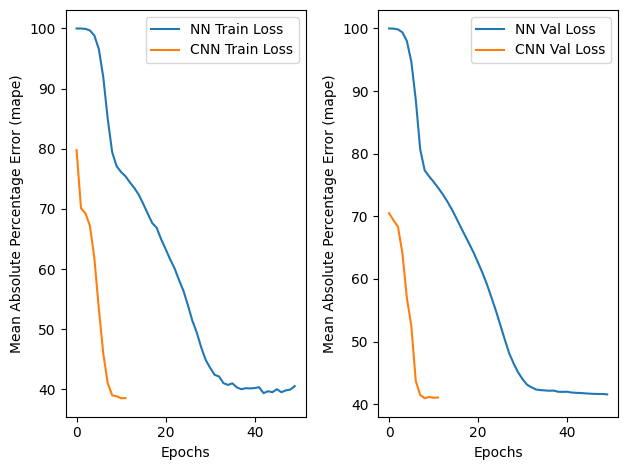

In [26]:
modelling.evaluate_models()

In [9]:
images = np.empty((2000, 512, 512, 3), dtype=np.uint8)
print(getsizeof(images)/1024/1024)

1500.0001525878906
